In [1]:
import operator as op
import src.ea.ea_lib as ea
import src.ea.problem_data as pb
import src.ea.utilities as ut
import random as rd
import time
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
from datetime import date
import pandas as pd
import statistics as stat
import importlib
import argparse
import shutil




In [2]:
#MOEA CGP


#Import parameters
param_arg = 'experiments.param_files.params'
prm = importlib.import_module(param_arg)
params_dict = vars(prm)

#Create output path
experiment_output_path = os.path.join(*prm.output_path,"")
experiment_output_path = ut.verify_path(experiment_output_path)

#Parameters file
params_file_path = os.path.join(experiment_output_path,'params.csv')
params_vars = vars(prm)
bad = lambda k: k.startswith("__") or isinstance(k, classmethod)
params_dict = {k:[str(v)] for k,v in params_vars.items() if not bad(k)}
params_df = pd.DataFrame(params_dict)
params_df.to_csv(params_file_path, index=False)

#Logs initialization
experiment_gen_logs = pd.DataFrame()
experiment_ind_logs = pd.DataFrame()

#Methods
def evaluate_ind(ind, semantic_indexes, dataset, objectives, active_altered, test=False):

    #Data test or train
    if test:
        x = dataset.x_train
        y = dataset.y_train
    else:
        x = dataset.x_test
        y = dataset.y_test

    #Graph evaluated if active nodes or output nodes were altered:
    if active_altered:
        outputs = {}
        for i,data_row in enumerate(x):
            output_dict = ind.representation.evaluate(data_row = data_row)

            #Extracting the 0th index output gene (only one output gene)
            output = output_dict[0]

            #The raw output needs to be transformed
            transformed_output = ut.threshold_map(value = output
                    ,threshold = prm.numeric_output_mapping_threshold
                    ,output_up = dataset.labels[prm.label_index_above_threshold]
                    ,output_down = dataset.labels[prm.label_index_below_threshold])
            outputs[i] = transformed_output

        #Each objective has its own evaluation method
        for obj_idx, obj_name in enumerate(prm.objective_names):
            if obj_name == "accuracy_in_label":
                val = ut.accuracy_in_label(y = y, y_output = outputs, label = dataset.labels[prm.accuracy_label_index[obj_idx]])
            elif obj_name == "accuracy":
                val = ut.accuracy(y = y, y_output = outputs)
            elif obj_name == "active_nodes":
                val = len(ind.representation.active_genotype)
            ind.update_evaluation(objective = objectives[obj_idx], value = val)
    
        #Update individual values
        ind.update_semantics_all(semantics_all = outputs)
        if ind.parent is not None:
            ind.semantic_distance_from_parent = ea.semantic_distance(ind1 = ind
                                                ,ind2 = ind.parent
                                                ,semantic_indexes = semantic_indexes)
            ind.damaged_semantics_from_parent = 0
            ind.improved_semantics_from_parent = 0
            for y_idx in semantic_indexes:
                if ind.semantics_all[y_idx] != ind.parent.semantics_all[y_idx]:
                    if ind.semantics_all[y_idx] == y[y_idx]:
                        ind.improved_semantics_from_parent = ind.improved_semantics_from_parent + 1
                    elif ind.parent.semantics_all[y_idx] == y[y_idx]:
                        ind.damaged_semantics_from_parent = ind.damaged_semantics_from_parent + 1
            ind.semantic_change_balance = ind.improved_semantics_from_parent - ind.damaged_semantics_from_parent
            ind.active_nodes_diff_from_parent = abs(len(ind.representation.active_genotype) - len(ind.parent.representation.active_genotype))/ind.representation.max_lenght
            ind.damaged_semantics_from_parent = ind.damaged_semantics_from_parent/len(semantic_indexes)
            ind.improved_semantics_from_parent = ind.improved_semantics_from_parent/len(semantic_indexes)
            ind.semantic_change_balance = ind.semantic_change_balance/len(semantic_indexes)

    #If the individual has no changes when compared to the parent
    else:
        ind.representation.evaluation_skipped = True
        for objective in objectives:
            ind.update_evaluation(objective = objective, value = ind.parent.evaluations[objective.name])
        ind.update_semantics_all(semantics_all = ind.parent.semantics_all)
        ind.damaged_semantics_from_parent = 0
        ind.improved_semantics_from_parent = 0
        ind.semantic_change_balance = 0
        ind.semantic_distance_from_parent = 0
        ind.active_nodes_diff_from_parent = 0
    

def sort_pop_moea(population, objectives, nsgaii_objectives, spea2_objective, sp_obj, test=False):
    if prm.moea_sorting_method == "NSGAII":
        sorted_population = ea.fast_nondominated_sort(population, objectives, nsgaii_objectives)
    elif prm.moea_sorting_method == "SPEA2":
        sorted_population = ea.spea2_sort(population, objectives, spea2_objective)
    elif prm.moea_sorting_method == "NSGAII_SP":
        ea.semantic_peculiarity(population = population, output_vector = dataset.y_train, semantic_indexes = semantic_indexes, sp_objective = sp_obj, b = prm.semantic_peculiarity_b)
        ea.set_ranks(population = population, conflicting_objectives = objectives, front_objective = front_objective)
        sorted_population = ea.sort_population(population = population, objectives=[front_objective, sp_obj])
    return sorted_population


def create_offspring(parent_population, current_gen):

    #Selection
    parent_index = ea.tournament_selection_index(population_size = len(parent_population), tournament_size = prm.tournament_size)
    parent = parent_population[parent_index]

    #Operator
    if prm.cgp_operator == "point":
        new_graph, active_altered = cgp.point_mutation(graph = parent.representation, percentage = prm.point_mutation_percentage)
    elif prm.cgp_operator == "sam":
        active_altered = True
        new_graph = cgp.single_active_mutation(graph = parent.representation)
    elif prm.cgp_operator == "accum":
        active_altered = True
        new_graph, accum_count = cgp.accummulating_mutation(graph = parent.representation, percentage = prm.point_mutation_percentage)
    elif prm.cgp_operator == "sasam":
        original_parent = parent
        for attempt in range(prm.max_sasam_attempts):
            new_graph = cgp.single_active_mutation(graph = parent.representation)
            #Create offspring
            offspring = ea.Individual(representation = new_graph
                                ,created_in_gen = current_gen
                                ,parent_index = parent_index
                                ,parent = original_parent)
            #Free up memory forgetting parents from the parents
            if offspring.parent is not None:
                offspring.parent.parent = None
            #Evaluate offspring
            offspring.update_evaluation(objective = generation_objective, value = current_gen)
            evaluate_ind(offspring, semantic_indexes, dataset, objectives, True)
            if ind.semantic_distance_from_parent != 0:
                return offspring
            else:
                parent = offspring
        return offspring

    #Create offspring
    offspring = ea.Individual(representation = new_graph
                            ,created_in_gen = current_gen
                            ,parent_index = parent_index
                            ,parent = parent)

    #Free up memory forgetting parents from the parents
    if offspring.parent is not None:
        offspring.parent.parent = None

    #Evaluate offspring
    offspring.update_evaluation(objective = generation_objective, value = current_gen)
    evaluate_ind(offspring, semantic_indexes, dataset, objectives, active_altered)

    return offspring



for trial in range(prm.trials):

    #Initialization
    individual_level_logs = []
    gen_level_logs = []
    current_gen = 0

    #Create trial path
    output_path = os.path.join(experiment_output_path, str(trial), "")
    path = ut.verify_path(output_path)
    
    #Load dataset
    dataset = pb.Dataset()
    dataset.load_problem(name = prm.dataset_name)
    dataset.split_data(train_rate = prm.train_test_rate)
    dataset.print_dataset_details()

    #Semantics
    n_semantic_indexes = int(dataset.x_train.shape[0]*prm.semantic_size_rate)
    semantic_indexes = set(rd.sample(list(range(dataset.x_train.shape[0])), k=n_semantic_indexes))

    #CGP
    cgp = ea.CGP_Representation(n_inputs = dataset.x_train.shape[1]
        ,n_outputs = prm.n_outputs
        ,levels_back = prm.levels_back
        ,n_rows = prm.n_rows
        ,n_columns = prm.n_columns
        ,allow_input_to_output = prm.allow_input_to_output
        ,inputs_available_to_all_columns = prm.allow_input_to_output
        ,functions = [op.add,op.sub,op.mul,ut.safe_divide_one])

    #objectives
    objectives = []
    for obj_idx, obj_name in enumerate(prm.objective_names):
        if  obj_name == "accuracy_in_label":
            obj_name = obj_name + "_" + str(dataset.labels[prm.accuracy_label_index[obj_idx]])
        obj = ea.Objective(name = obj_name
                            ,to_max = prm.objective_to_max[obj_idx]
                            ,best = prm.objective_best[obj_idx]
                            ,worst = prm.objective_worst[obj_idx])
        objectives.append(obj)
    generation_objective = ea.Objective(name = "generation", to_max = True)
    nsgaii_objectives = ea.get_nsgaii_objectives()
    front_objective = nsgaii_objectives[0]
    cd_objective = nsgaii_objectives[1]
    spea2_objective = ea.get_spea2_objective()
    sp_obj = ea.get_semantic_peculiarity_objective()

    #Initial population
    graphs = [cgp.create_random(seed = rd.random()) for _ in range(prm.population_size)]
    parent_population = [ea.Individual(graphs[i], created_in_gen = 0) for i in range(prm.population_size)]
    for ind in parent_population:
        evaluate_ind(ind, semantic_indexes, dataset, objectives, True)
        ind.update_evaluation(objective = generation_objective, value = current_gen)
    parent_population = sort_pop_moea(parent_population, objectives, nsgaii_objectives, spea2_objective, sp_obj)
    offspring_population = [create_offspring(parent_population, current_gen) for i in range(prm.population_size)]


    ## Main loop
    previous_hyperarea = 0
    stop_criteria_value = 0
    while(True):
    #for _ in range(prm.generations):

        
        #Population management.
        population = parent_population + offspring_population
        sorted_population = sort_pop_moea(population, objectives, nsgaii_objectives, spea2_objective, sp_obj)

        #Logs
        hyperarea = ea.hyperarea(sorted_population, objectives, front_objective)
        header, logs, g_header, g_logs = ea.get_cgp_log(sorted_population, cgp, current_gen)
        front_pop = [i for i in sorted_population if i.evaluations[front_objective.name]==1]
        _, _, front_g_header, front_g_logs = ea.get_cgp_log(front_pop, cgp, current_gen)
        front_g_header = ["front_"+i for i in front_g_header]
        g_logs += front_g_logs + [hyperarea]
        g_header += front_g_header + ["Hyperarea"]
        individual_level_logs += logs
        gen_level_logs += [g_logs]
        if (current_gen+1)%10==0:
            ea.plot_pareto(sorted_population, objectives, "size", path = path, name = "plt_size_g"+str(current_gen))
            ea.plot_pareto(sorted_population, objectives, "color", path = path, name = "plt_color_g"+str(current_gen))
            ut.logs_to_file(individual_level_logs, "Ind_logs", path)
            ut.logs_to_file(gen_level_logs, "Gen_logs", path)

        if previous_hyperarea > hyperarea:
            print("Damaged hyperarea")
            #break
        else:
            previous_hyperarea = hyperarea

        #Offspring generation
        parent_population = sorted_population[:prm.population_size]

        current_gen = current_gen + 1
        offspring_population = [create_offspring(parent_population, current_gen) for i in range(prm.population_size)]

        #Stop criteria fitness_evaluations, node_evaluations, generations 
        if prm.stopping_criteria == "generations":
            stop_criteria_value = current_gen
            print(prm.stopping_criteria, ": ", str(stop_criteria_value), "of", str(prm.stop_value))
            if stop_criteria_value > prm.stop_value:
                break
        elif prm.stopping_criteria == "fitness_evaluations":
            temp_idx = g_header.index("Fitness_evals")
            stop_criteria_value += g_logs[temp_idx]
            print(prm.stopping_criteria, ": ", str(stop_criteria_value), "of", str(prm.stop_value))
            if stop_criteria_value > prm.stop_value:
                break
        elif prm.stopping_criteria == "node_evaluations":
            temp_idx = g_header.index("Eval_nodes")
            stop_criteria_value += g_logs[temp_idx]
            print(prm.stopping_criteria, ": ", str(stop_criteria_value), "of", str(prm.stop_value))
            if stop_criteria_value > prm.stop_value:
                break
        else:
            print("Wrong stop critera")
            break

    #Final logs
    individual_level_logs.insert(0, header)
    ut.logs_to_file(individual_level_logs, "Ind_logs", path)
    gen_level_logs.insert(0, g_header)
    ut.logs_to_file(gen_level_logs, "Gen_logs", path)

    #Test evaluation
    population = parent_population + offspring_population
    for ind in population:
        evaluate_ind(ind, semantic_indexes, dataset, objectives, True, True)
    population = sort_pop_moea(population, objectives, nsgaii_objectives, spea2_objective, sp_obj)

    #Logs
    test_g_logs = []
    hyperarea = ea.hyperarea(population, objectives, front_objective)
    header, logs, g_header, g_logs = ea.get_cgp_log(population, cgp, current_gen)
    g_logs+= [hyperarea]
    g_header += ["Hyperarea"]
    test_g_logs += [g_logs]
    ea.plot_pareto(population, objectives, "size", path = path, name = "plt_size_test")
    ea.plot_pareto(population, objectives, "color", path = path, name = "plt_color_test")
    logs.insert(0, header)
    ut.logs_to_file(logs, "Test_ind_logs", path)
    test_g_logs.insert(0, g_header)
    ut.logs_to_file(test_g_logs, "Test_gen_logs", path)
    

    

c:\Users\fredx\Documents\Gits\Generic_EA\src\ea\problem_data.py:38: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  data = np.genfromtxt(path + "ionosphere.dat"
train_shape (175, 34)
test_shape (176, 34)
train_label_count {0: 63, 1: 112}
test_label_count {0: 63, 1: 113}
current_gen 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

ZeroDivisionError: division by zero

In [13]:
#Semantic peculiarity test

#Logs params
now = datetime.now()
time_string = now.strftime('%Y_%m_%d-%H_%M_%S')
output_path = os.path.join("outputs","semantic_peculiarity", time_string, "")
output_path = ut.verify_path(output_path)

# Dataset
rd.seed(0)
dataset = pb.Dataset()
dataset.load_problem(name = "even_parity5")

## CGP definition
cgp = ea.CGP_Representation(
            n_inputs = dataset.x_train.shape[1]
            ,n_outputs = 1
            ,levels_back = 100
            ,n_rows = 1
            ,n_columns = 100
            ,allow_input_to_output = True
            ,inputs_available_to_all_columns = True
            ,functions = [op.add,op.sub,op.mul,ut.safe_divide_one])

# Semantic definition
semantic_indexes = list(range(dataset.x_train.shape[0]))

# Objectives
sp_obj = ea.get_semantic_peculiarity_objective(name = "sp")
acc_obj = ea.Objective(name="acc", to_max = True, best=1, worst=0)

# Evaluation
def evaluate_ind(ind, dataset, obj, mapping_threshold=0):
    outputs = {}
    for i,data_row in enumerate(dataset.x_train):
        output_dict = ind.representation.evaluate(data_row = data_row)
        #Extracting the output from the 0th output gene
        output = output_dict[0]
        #Mapping the numerical output
        mapped_output = ut.threshold_map(value = output, threshold = mapping_threshold, output_up = dataset.labels[1], output_down = dataset.labels[0])
        outputs[i] = mapped_output
    #Each objective has its own evaluation method
    ind.update_semantics_all(semantics_all = outputs)
    acc = ut.accuracy(y = dataset.y_train, y_output = outputs)
    ind.update_evaluation(objective = obj, value = acc)


# Experiment
pop_size = 100
graphs = [cgp.create_random(seed = rd.random()) for _ in range(pop_size)]
population = [ea.Individual(graphs[i], created_in_gen = 0) for i in range(pop_size)]

for ind in population:
    evaluate_ind(ind, dataset, acc_obj)

semantic_peculiarity, semantic_relevance, represented_fs = ea.semantic_peculiarity(population, dataset.y_train, semantic_indexes, sp_obj, 1)
#population = ea.sort_population(population, [sp_obj])
for ind_idx, ind in enumerate(population):
    print(str(represented_fs[ind_idx]), ind.evaluations)
print("semantic_relevance")
for i, sr in enumerate(semantic_relevance.values()):
    print(i, sr)
names = list(population[0].evaluations.keys())
v1 = np.array([ind.evaluations[names[0]] for ind in population])
v2 = np.array([ind.evaluations[names[1]] for ind in population])
print(str(np.corrcoef(v1, v2)))

[1, 3, 4, 6, 8, 10, 13, 15, 16, 18, 21, 23, 25, 27, 28, 30] {'acc': 0.5, 'sp': 0.2471875}
[1, 3, 4, 6, 8, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 31] {'acc': 0.5, 'sp': 0.24531249999999993}
[0, 1, 3, 6, 10, 12, 13, 15, 18, 20, 21, 23, 24, 25, 27, 30] {'acc': 0.5, 'sp': 0.26249999999999996}
[0, 3, 5, 6, 9, 10, 12, 15, 17, 18, 20, 23, 24, 27, 29, 30] {'acc': 0.5, 'sp': 0.26875}
[0, 1, 6, 7, 10, 12, 13, 15, 18, 19, 20, 21, 25, 28, 30, 31] {'acc': 0.5, 'sp': 0.259375}
[1, 2, 4, 7, 8, 11, 13, 14, 16, 21, 22, 23, 25, 26, 27, 28] {'acc': 0.5, 'sp': 0.23374999999999996}
[4, 6, 7, 8, 10, 11, 16, 17, 18, 19, 25, 30, 31] {'acc': 0.40625, 'sp': 0.20093750000000005}
[1, 2, 4, 7, 8, 11, 12, 14, 16, 19, 21, 22, 25, 26, 29, 31] {'acc': 0.5, 'sp': 0.2340625}
[1, 3, 5, 6, 8, 10, 12, 15, 16, 19, 20, 23, 25, 26, 29, 30] {'acc': 0.5, 'sp': 0.24656250000000002}
[1, 2, 4, 7, 8, 11, 13, 14, 16, 19, 21, 22, 25, 26, 28, 31] {'acc': 0.5, 'sp': 0.23312499999999997}
[1, 2, 4, 7, 8, 11, 13, 14, 16, 19, 21, 25, 26, 

In [2]:
#Semantics experiment

#Methods
def evaluate_ind(ind, dataset, objective):
    """
    Evaluate the individual with acc0 and acc1
    """
    outputs = {}
    for i,data_row in enumerate(dataset.x_train):
        output_dict = ind.representation.evaluate(data_row = data_row)
        #Extracting the 0th index output gene
        output = output_dict[0]
        #The raw output need to be transformed
        #transformed_output = ut.custom_round(output)
        mapped_output = ut.threshold_map(value = output,threshold = mapping_threshold, output_up = dataset.labels[1], output_down = dataset.labels[0])
        outputs[i] = mapped_output
    #Each objective has its own evaluation method
    ind.update_semantics_all(semantics_all = outputs)
    acc = ut.accuracy(y = dataset.y_train, y_output = outputs)
    ind.update_evaluation(objective = acc_obj, value = acc)


## Experiment parameters
generations = 5000
problem_name = "ion"
#problem_names = ion, spect, yst_m3, yst_mit
seed = 0
rd.seed(seed)
now = datetime.now()
time_string = now.strftime('%Y_%m_%d-%H_%M_%S')
mapping_threshold = 0
output_path = os.path.join("outputs","semantic_distances","point9",problem_name + "-" + time_string, "") #define
output_path = ut.verify_path(output_path)

#Initialize the logs
sem_logs = pd.DataFrame()
final_log = pd.DataFrame()

#Loop
for i in range(4):

    ## CGP params
    levels_back = 200 + i*50
    n_rows = 1
    n_columns = 200 + i*50
    n_outputs = 1
    allow_input_to_output = True
    inputs_available_to_all_columns = True
    functions = [op.add,op.sub,op.mul,ut.safe_divide_one]
    functions_as_string = "[op.add,op.sub,op.mul,ut.safe_divide_one]"
    mutation_percentage = 9

    #Instantiation
    acc_obj = ea.Objective(name="acc", to_max = True, best=1, worst=0, eval_function = ut.accuracy)
    tpr_obj = ea.Objective(name="tpr", to_max = True, best=1, worst=0, eval_function = ut.accuracy_in_label)
    tnr_obj = ea.Objective(name="tnr", to_max = True, best=1, worst=0, eval_function = ut.accuracy_in_label)
    dataset = pb.Dataset()
    dataset.load_problem(name = problem_name)
    data_rows = dataset.x_train.shape[0]
    semantic_indexes = list(range(data_rows))
    cgp = ea.CGP_Representation(
                dataset.x_train.shape[1]
                ,n_outputs
                ,levels_back
                ,n_rows 
                ,n_columns
                ,allow_input_to_output
                ,inputs_available_to_all_columns
                ,*functions)

    #Initial random ind
    graph = cgp.create_random(seed = rd.random())
    ind = ea.Individual(graph, created_in_gen = 0)
    evaluate_ind(ind, dataset, acc_obj)

    start_time = time.time()
    for gen in range(generations):

        ##Generate the new ind
        #new_graph = cgp.single_active_mutation(ind.representation)
        #altered=True
        #new_graph, muts = cgp.accummulating_mutation(ind.representation, mutation_percentage)
        new_graph, altered = cgp.point_mutation(ind.representation, mutation_percentage) #point
        new_ind = ea.Individual(new_graph, created_in_gen = 0)
        evaluate_ind(new_ind, dataset, acc_obj)

        #Logs
        row = {
            "max_nodes":cgp.n_function_nodes
            ,"prev_actives":len(ind.representation.active_genotype)
            ,"new_actives":len(new_ind.representation.active_genotype)
            ,"actives_change":len(new_ind.representation.active_genotype) - len(ind.representation.active_genotype)
            ,"prev_actives_rate":len(ind.representation.active_genotype) / cgp.n_function_nodes
            ,"new_actives_rate":len(new_ind.representation.active_genotype) / cgp.n_function_nodes
            ,"actives_change_rate":(len(new_ind.representation.active_genotype) - len(ind.representation.active_genotype))/cgp.n_function_nodes
            ,"semantic_distance":ea.semantic_distance(ind, new_ind, semantic_indexes)
            ,"altered":altered
            }
        sem_logs = sem_logs.append(row, ignore_index = True)

        #Reset variables for the loop to work
        ind = new_ind

    total_time = time.time() - start_time

    #Extract the subsets from the logs
    current_logs = sem_logs[sem_logs["max_nodes"]==cgp.n_function_nodes]
    sd_when_altered = list(current_logs.loc[current_logs["altered"]==True,"semantic_distance"]) #point

    #Calculations
    avg_sd = stat.mean(list(current_logs["semantic_distance"]))
    stdev_sd = stat.stdev(list(current_logs["semantic_distance"]))
    avg_actives = stat.mean(list(current_logs["prev_actives"]))
    altered_rate = sum(list(current_logs["altered"]))/generations
    if len(sd_when_altered) > 0:
        avg_sd_when_altered = stat.mean(sd_when_altered)
        stdev_sd_when_altered = stat.stdev(sd_when_altered)
    else:
        avg_sd_when_altered = 0
        stdev_sd_when_altered = 0
    f_l = {"avg_sd":avg_sd
            ,"stdev_sd":stdev_sd
            ,"avg_actives":avg_actives
            ,"generations":generations
            ,"total_time":total_time
            ,"avg_gen_time":total_time/generations
            ,"rd.seed":seed
            ,"levels_back ":levels_back
            ,"n_rows ":n_rows
            ,"n_columns ":n_columns
            ,"n_outputs ":n_outputs
            ,"n_inputs":cgp.n_inputs
            ,"functions ":functions_as_string
            ,"fitness_cases":len(dataset.y_train)
            ,"mutation_percentage ": mutation_percentage
            ,"altered_rate":altered_rate
            ,"avg_sd_when_altered":avg_sd_when_altered
            ,"stdev_sd_when_altered":stdev_sd_when_altered
            }
    final_log = final_log.append(f_l, ignore_index = True)
    print(str(f_l))

sem_logs.to_csv(os.path.join(output_path, "Sem_logs"))
final_log.to_csv(os.path.join(output_path, "Exp_logs"))
    


c:\Users\fredx\Documents\Gits\Generic_EA\src\ea\problem_data.py:23: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  data = np.genfromtxt(path + "ionosphere.dat"
{'avg_sd': 0.2374017094017094, 'stdev_sd': 0.22594902522170418, 'avg_actives': 5.5764, 'generations': 5000, 'total_time': 199.04613208770752, 'avg_gen_time': 0.039809226417541504, 'rd.seed': 0, 'levels_back ': 200, 'n_rows ': 1, 'n_columns ': 200, 'n_outputs ': 1, 'n_inputs': 34, 'functions ': '[op.add,op.sub,op.mul,ut.safe_divide_one]', 'fitness_cases': 351, 'mutation_percentage ': 9, 'altered_rate': 0.6392, 'avg_sd_when_altered': 0.3714044264732625, 'stdev_sd_when_altered': 0.1734771762710499}
c:\Users\fredx\Documents\Gits\Generic_EA\src\ea\problem_data.py:23: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.


In [64]:
import pandas as pd
import statistics as stat
import os
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

#Definition
split_paths = {0:["outputs",'ion_point6_NSGAII_2021_05_05-01_27_19']
               ,1:["outputs",'ion_sam_NSGAII_SP_2021_05_06-02_40_52']
              ,2:["outputs",'good_ion_accum6_SPEA2_2021_05_06-03_59_08','19']
              ,3:["outputs",'good_ion_accum_NSGAII_2021_05_05-01_26_28','19']
              ,4:["outputs",'good_ion_sam_SPEA2_2021_05_04-14_11_04','19']
              ,5:["outputs","good_ion_sam_NSGAII_2021_05_04-05_06_31","19"]
              }
exp_names = [x[1].split("_2021")[0].split("ion_")[1] for x in split_paths.values()]



file_name = "Gen_logs.csv"
gen_logs = {}
for k,path in split_paths.items():
    file_path = os.path.join(*path,file_name)
    gen_logs[k] = pd.read_csv(file_path)

#Aggregate by gen
semantic_damage_bars = defaultdict(lambda: [])
for i,gen_log in gen_logs.items():
    for gen in range(max(gen_log["Gen"])):
        damage_mean = stat.mean(gen_log.loc[gen_log["Gen"]==gen,"Avg_damaged_semantics_from_parent"])
        improvement_mean = stat.mean(gen_log.loc[gen_log["Gen"]==gen,"Avg_improved_semantics_from_parent"])
        hyperarea_mean = stat.mean(gen_log.loc[gen_log["Gen"]==gen,"Hyperarea"])
        semantic_damage_bars[i].append([gen,damage_mean,improvement_mean,hyperarea_mean])

orig_semantic_damage_bars = semantic_damage_bars
semantic_damage_bars = {k:np.array(a).T.tolist() for k,a in semantic_damage_bars.items()}

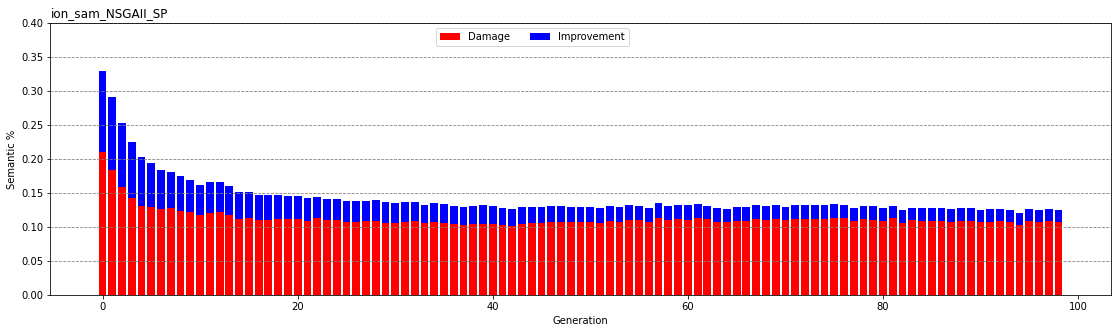

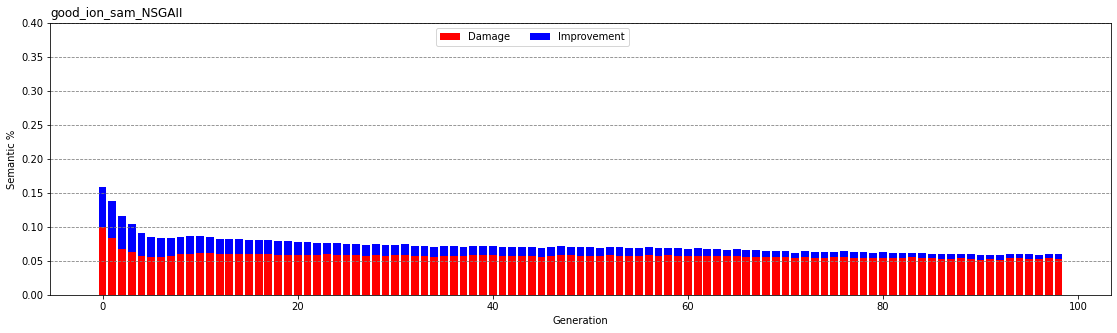

In [65]:
for i in [1,5]:#range(len(semantic_damage_bars)):
    fig, ax = plt.subplots(1, figsize=(19, 5))
    plt.bar(semantic_damage_bars[i][0], semantic_damage_bars[i][1], color='red')
    plt.bar(semantic_damage_bars[i][0], semantic_damage_bars[i][2], bottom = semantic_damage_bars[i][1], color='blue')
    plt.title(split_paths[i][1].split("_2021")[0], loc='left')
    plt.legend(["Damage","Improvement"], bbox_to_anchor=([0.55, 1, 0, 0]), ncol=2, frameon=True)
    plt.xlabel('Generation')
    plt.ylabel('Semantic %')
    ax.yaxis.grid(color='gray', linestyle='dashed')
    plt.ylim(0,0.4)
    
    plt.show()

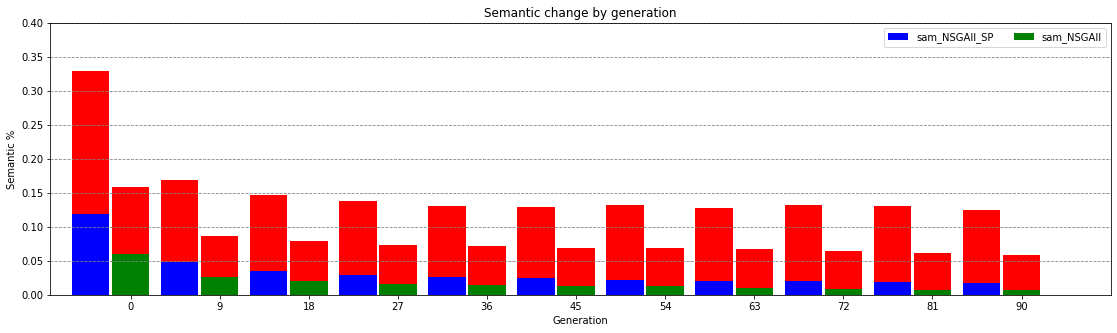

In [62]:
gen_jump = 9
exp_idx = [1,5]

bars = len(exp_idx)
all_colors = ['b','g','c','m','y','k']
colors = [all_colors[i] for i in range(bars)]
x_space = 0.9
width = x_space/bars


#Aggregate by gen
semantic_damage_bars = defaultdict(lambda: [])
for i,gen_log in gen_logs.items():
    gens = list(range(0, max(gen_log["Gen"]), gen_jump))
    n_gens = len(gens)
    for gen in gens:
        damage_mean = stat.mean(gen_log.loc[gen_log["Gen"]==gen,"Avg_damaged_semantics_from_parent"])
        improvement_mean = stat.mean(gen_log.loc[gen_log["Gen"]==gen,"Avg_improved_semantics_from_parent"])
        hyperarea_mean = stat.mean(gen_log.loc[gen_log["Gen"]==gen,"Hyperarea"])
        semantic_damage_bars[i].append([gen,damage_mean,improvement_mean,hyperarea_mean])

orig_semantic_damage_bars = semantic_damage_bars
semantic_damage_bars = {k:np.array(a).T.tolist() for k,a in semantic_damage_bars.items()}


fig, ax = plt.subplots(1, figsize=(19, 5))
#for i in range(len(semantic_damage_bars)):
for i,exp in enumerate(exp_idx):
    #plt.bar([x-x_space/2+(i*width) for x in range(n_gens)], semantic_damage_bars[exp][1], bottom = semantic_damage_bars[exp][2], color='red', width = width)
    plt.bar([x-x_space/2+(i*width) for x in range(n_gens)], semantic_damage_bars[exp][2], color=colors[i], width = width-0.03)
plt.title("Semantic change by generation")
#legends = ["Damage"] + [exp_names[i] for i in exp_idx]
legends = [exp_names[i] for i in exp_idx]
plt.legend(legends, bbox_to_anchor=(1,1), ncol=bars, frameon=True,loc="upper right")
for i,exp in enumerate(exp_idx):
    plt.bar([x-x_space/2+(i*width) for x in range(n_gens)], semantic_damage_bars[exp][1], bottom = semantic_damage_bars[exp][2], color='red', width = width-0.03)
plt.xlabel('Generation')
plt.ylabel('Semantic %')
ax.yaxis.grid(color='gray', linestyle='dashed')
plt.ylim(0,0.4)
plt.xlim(-x_space,n_gens)
plt.xticks(list(range(n_gens)),gens)

plt.show()

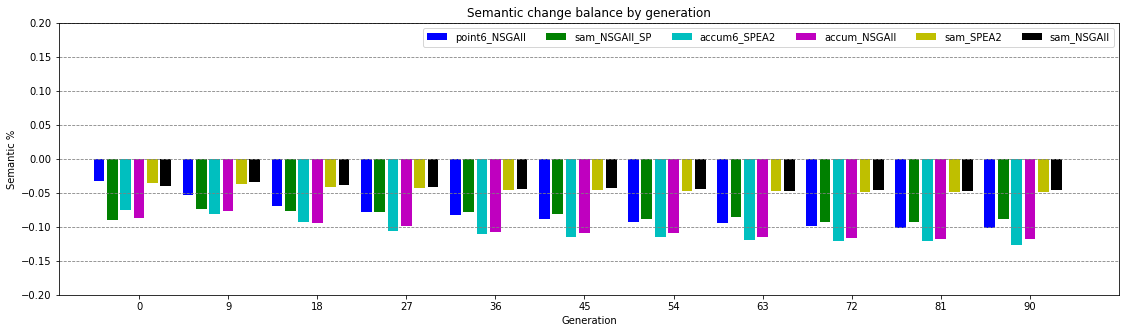

In [57]:
gen_jump = 9
exp_idx = [0,1,2,3,4,5]

bars = len(exp_idx)
all_colors = ['b','g','c','m','y','k']
colors = [all_colors[i] for i in range(bars)]
x_space = 0.9
width = x_space/bars


#Aggregate by gen
semantic_damage_bars = defaultdict(lambda: [])
for i,gen_log in gen_logs.items():
    gens = list(range(0, max(gen_log["Gen"]), gen_jump))
    n_gens = len(gens)
    for gen in gens:
        damage_mean = stat.mean(gen_log.loc[gen_log["Gen"]==gen,"Avg_damaged_semantics_from_parent"])
        improvement_mean = stat.mean(gen_log.loc[gen_log["Gen"]==gen,"Avg_improved_semantics_from_parent"])
        balance = stat.mean(gen_log.loc[gen_log["Gen"]==gen,"Avg_semantic_change_balance"])
        hyperarea_mean = stat.mean(gen_log.loc[gen_log["Gen"]==gen,"Hyperarea"])
        semantic_damage_bars[i].append([gen,damage_mean,improvement_mean,hyperarea_mean,balance])

orig_semantic_damage_bars = semantic_damage_bars
semantic_damage_bars = {k:np.array(a).T.tolist() for k,a in semantic_damage_bars.items()}


fig, ax = plt.subplots(1, figsize=(19, 5))
#for i in range(len(semantic_damage_bars)):
for i,exp in enumerate(exp_idx):
    #plt.bar([x-x_space/2+(i*width) for x in range(n_gens)], semantic_damage_bars[exp][1], bottom = semantic_damage_bars[exp][2], color='red', width = width)
    plt.bar([x-x_space/2+(i*width) for x in range(n_gens)], semantic_damage_bars[exp][4], color=colors[i], width = width-0.03)
plt.title("Semantic change balance by generation")
#legends = ["Damage"] + [exp_names[i] for i in exp_idx]
legends = [exp_names[i] for i in exp_idx]
plt.legend(legends, bbox_to_anchor=(1,1), ncol=bars, frameon=True,loc="upper right")
#for i,exp in enumerate(exp_idx):
#    plt.bar([x-x_space/2+(i*width) for x in range(n_gens)], semantic_damage_bars[exp][1], bottom = semantic_damage_bars[exp][2], color='red', width = width-0.03)
plt.xlabel('Generation')
plt.ylabel('Semantic %')
ax.yaxis.grid(color='gray', linestyle='dashed')
plt.ylim(-0.2,0.2)
plt.xlim(-x_space,n_gens)
plt.xticks(list(range(n_gens)),gens)

plt.show()

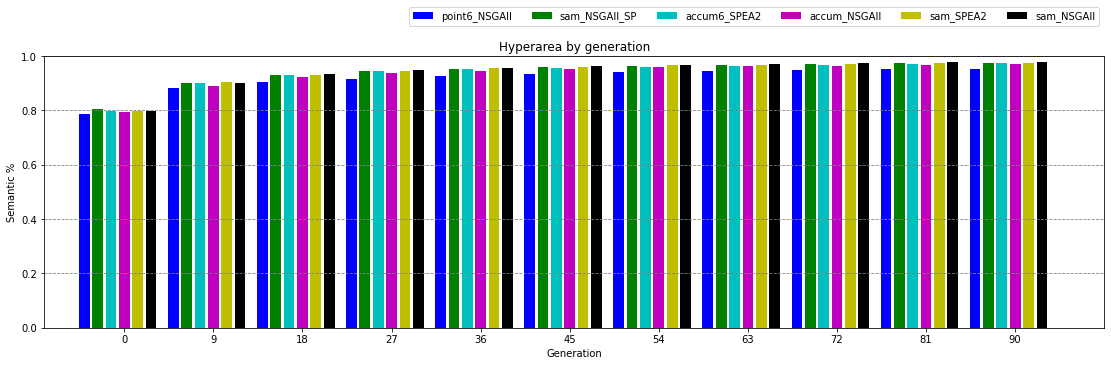

In [61]:
gen_jump = 9
exp_idx = [0,1,2,3,4,5]

bars = len(exp_idx)
all_colors = ['b','g','c','m','y','k']
colors = [all_colors[i] for i in range(bars)]
x_space = 0.9
width = x_space/bars


#Aggregate by gen
semantic_damage_bars = defaultdict(lambda: [])
for i,gen_log in gen_logs.items():
    gens = list(range(0, max(gen_log["Gen"]), gen_jump))
    n_gens = len(gens)
    for gen in gens:
        damage_mean = stat.mean(gen_log.loc[gen_log["Gen"]==gen,"Avg_damaged_semantics_from_parent"])
        improvement_mean = stat.mean(gen_log.loc[gen_log["Gen"]==gen,"Avg_improved_semantics_from_parent"])
        balance = stat.mean(gen_log.loc[gen_log["Gen"]==gen,"Avg_semantic_change_balance"])
        hyperarea_mean = stat.mean(gen_log.loc[gen_log["Gen"]==gen,"Hyperarea"])
        semantic_damage_bars[i].append([gen,damage_mean,improvement_mean,hyperarea_mean,balance])

orig_semantic_damage_bars = semantic_damage_bars
semantic_damage_bars = {k:np.array(a).T.tolist() for k,a in semantic_damage_bars.items()}


fig, ax = plt.subplots(1, figsize=(19, 5))
#for i in range(len(semantic_damage_bars)):
for i,exp in enumerate(exp_idx):
    #plt.bar([x-x_space/2+(i*width) for x in range(n_gens)], semantic_damage_bars[exp][1], bottom = semantic_damage_bars[exp][2], color='red', width = width)
    plt.bar([x-x_space/2+(i*width) for x in range(n_gens)], semantic_damage_bars[exp][3], color=colors[i], width = width-0.03)
plt.title("Hyperarea by generation")
#legends = ["Damage"] + [exp_names[i] for i in exp_idx]
legends = [exp_names[i] for i in exp_idx]
plt.legend(legends, bbox_to_anchor=(1,1.2), ncol=bars, frameon=True,loc="upper right")
#for i,exp in enumerate(exp_idx):
#    plt.bar([x-x_space/2+(i*width) for x in range(n_gens)], semantic_damage_bars[exp][1], bottom = semantic_damage_bars[exp][2], color='red', width = width-0.03)
plt.xlabel('Generation')
plt.ylabel('Semantic %')
ax.yaxis.grid(color='gray', linestyle='dashed')
plt.ylim(0,1)
plt.xlim(-x_space,n_gens)
plt.xticks(list(range(n_gens)),gens)

plt.show()

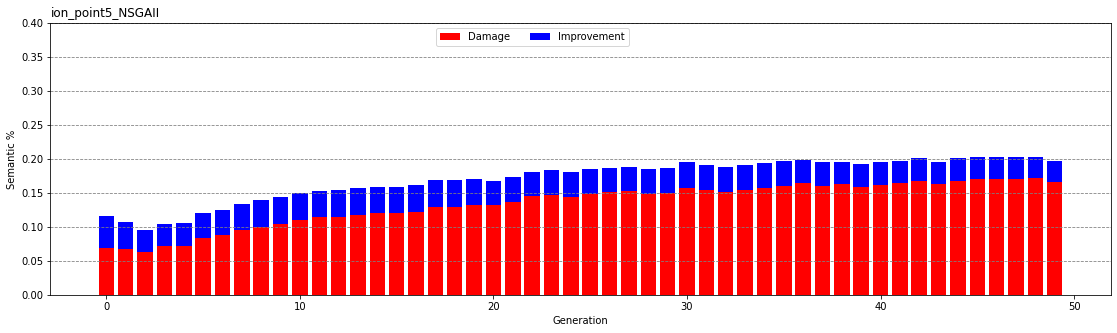

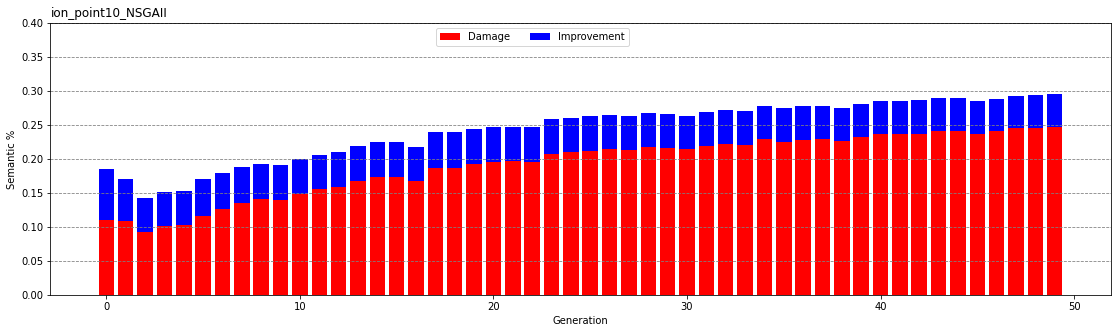

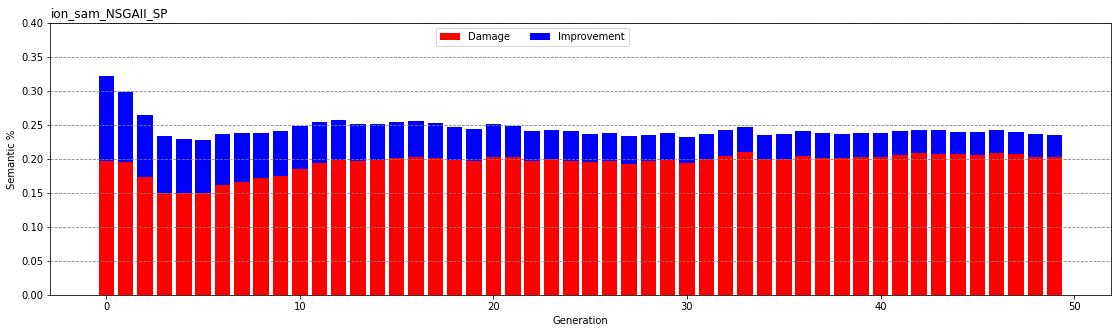

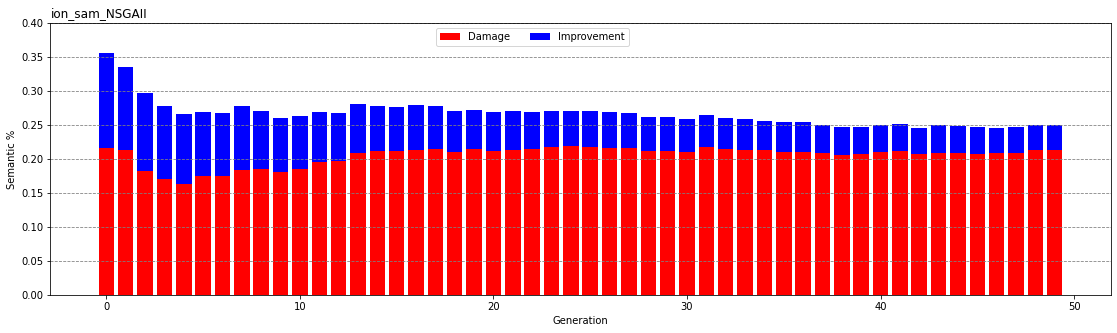

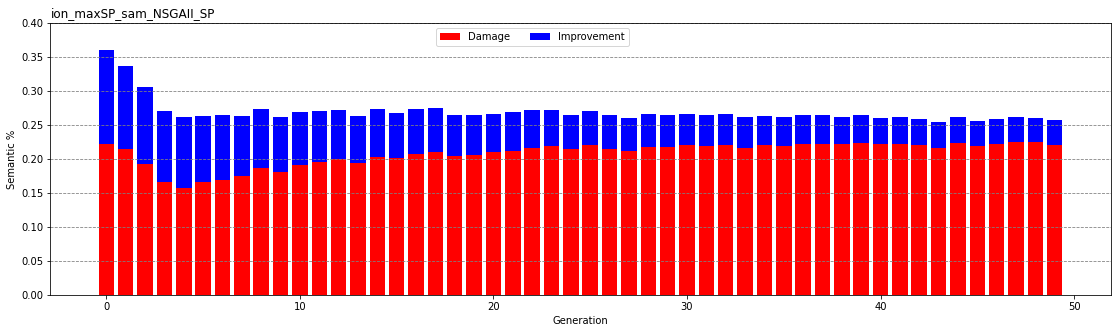

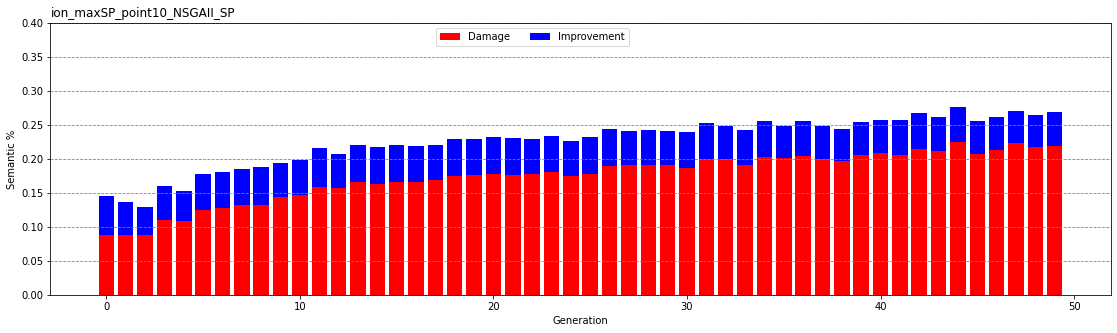

In [38]:
import pandas as pd
import statistics as stat
import os
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

#Definition
split_paths = {0:["outputs","ion_point5_NSGAII_2021_05_11-19_20_13"]
            ,1:["outputs","ion_point10_NSGAII_2021_05_11-19_23_39"]
            ,3:["outputs","ion_sam_NSGAII_SP_2021_05_14-17_32_55"]
            ,2:["outputs","ion_sam_NSGAII_2021_05_14-16_34_06"]
            ,4:["outputs","ion_maxSP_sam_NSGAII_SP_2021_05_14-05_04_24"]
            ,5:["outputs","ion_maxSP_point10_NSGAII_SP_2021_05_14-11_52_02"]
              }
exp_names = [x[1].split("_2021")[0].split("ion_")[1] for x in split_paths.values()]
trials = 30
max_gen = 50
columns = ["Gen"
            ,"Avg_damaged_semantics_from_parent"
            ,"Avg_improved_semantics_from_parent"
            ,"Hyperarea"
            ,"Avg_semantic_change_balance"
            ,"Fitness_evals"]

file_name = "Gen_logs.csv"
gen_logs = {}
for k,path in split_paths.items():
    trial_g_logs = {}
    for trial in range(trials):
        file_path = os.path.join(*path,str(trial),file_name)
        trial_g_logs[trial] = pd.read_csv(file_path)
    gen_logs[k] = trial_g_logs

#Aggregate by gen
semantic_damage_bars = defaultdict(lambda: [])
for exp_id,trial_g_log in gen_logs.items():
    damage = defaultdict(lambda: [])
    improvement = defaultdict(lambda: [])
    hyperarea = defaultdict(lambda: [])
    balance = defaultdict(lambda: [])
    fitness_evals = defaultdict(lambda: [])
    for trial in range(trials):
        gen_log = trial_g_log[trial]
        #for gen in range(max(gen_log["Gen"])):
        for gen in range(max_gen):
            damage[gen].append(list(gen_log.loc[gen_log[columns[0]]==gen,columns[1]])[0])
            improvement[gen].append(list(gen_log.loc[gen_log[columns[0]]==gen,columns[2]])[0])
            hyperarea[gen].append(list(gen_log.loc[gen_log[columns[0]]==gen,columns[3]])[0])
            balance[gen].append(list(gen_log.loc[gen_log[columns[0]]==gen,columns[4]])[0])
            fitness_evals[gen].append(list(gen_log.loc[gen_log[columns[0]]==gen,columns[5]])[0])
    for gen in damage.keys():
        damage_mean = stat.mean(damage[gen])
        improvement_mean = stat.mean(improvement[gen])
        hyperarea_mean = stat.mean(hyperarea[gen])
        balance_mean = stat.mean(balance[gen])
        fitness_evals_mean = stat.mean(balance[gen])
        semantic_damage_bars[exp_id].append([gen,damage_mean,improvement_mean,hyperarea_mean,balance_mean,fitness_evals_mean])


pd_logs = {k:pd.DataFrame(a, columns = columns) for k,a in semantic_damage_bars.items()}
orig_semantic_damage_bars = semantic_damage_bars
semantic_damage_bars = {k:np.array(a).T.tolist() for k,a in semantic_damage_bars.items()}


for i in split_paths.keys():#range(len(semantic_damage_bars)):
    fig, ax = plt.subplots(1, figsize=(19, 5))
    plt.bar(semantic_damage_bars[i][0], semantic_damage_bars[i][1], color='red')
    plt.bar(semantic_damage_bars[i][0], semantic_damage_bars[i][2], bottom = semantic_damage_bars[i][1], color='blue')
    
    plt.title(split_paths[i][1].split("_2021")[0], loc='left')
    plt.legend(["Damage","Improvement"], bbox_to_anchor=([0.55, 1, 0, 0]), ncol=2, frameon=True)
    plt.xlabel('Generation')
    plt.ylabel('Semantic %')
    ax.yaxis.grid(color='gray', linestyle='dashed')
    plt.ylim(0,0.4)
    
    plt.show()


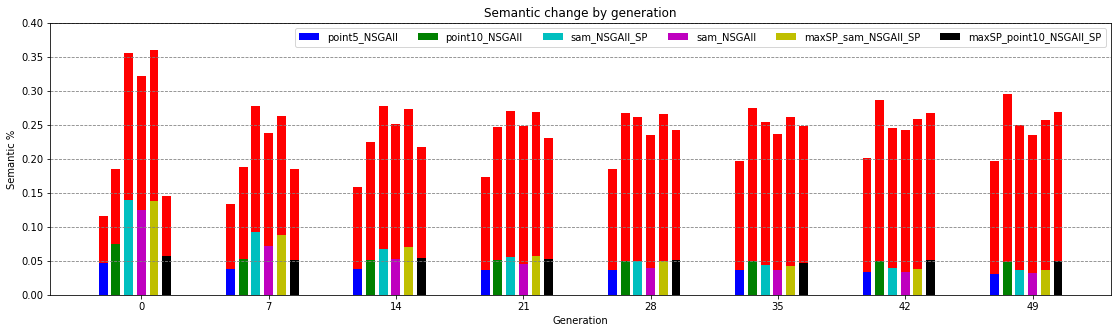

In [30]:
gen_jump = 7
exp_idx = [0,1,2,3,4,5]

bars = len(exp_idx)
all_colors = ['b','g','c','m','y','k']
colors = [all_colors[i] for i in range(bars)]
x_space = 0.6
width = x_space/bars


#Aggregate by gen
semantic_damage_bars = defaultdict(lambda: [])
for exp_id,trial_g_log in gen_logs.items():
    damage = defaultdict(lambda: [])
    improvement = defaultdict(lambda: [])
    hyperarea = defaultdict(lambda: [])
    n_gens_list = []
    for trial in range(trials):
        gen_log = trial_g_log[trial]
        #gens = list(range(0, max(gen_log["Gen"]), gen_jump))
        gens = list(range(0, max_gen, gen_jump))
        n_gens_list.append(len(gens))
        for gen in gens:
            damage[gen].append(list(gen_log.loc[gen_log["Gen"]==gen,"Avg_damaged_semantics_from_parent"])[0])
            improvement[gen].append(list(gen_log.loc[gen_log["Gen"]==gen,"Avg_improved_semantics_from_parent"])[0])
            hyperarea[gen].append(list(gen_log.loc[gen_log["Gen"]==gen,"Hyperarea"])[0])
    for gen in damage.keys():
        damage_mean = stat.mean(damage[gen])
        improvement_mean = stat.mean(improvement[gen])
        hyperarea_mean = stat.mean(hyperarea[gen])
        semantic_damage_bars[exp_id].append([gen,damage_mean,improvement_mean,hyperarea_mean])

orig_semantic_damage_bars = semantic_damage_bars
semantic_damage_bars = {k:np.array(a).T.tolist() for k,a in semantic_damage_bars.items()}
n_gens = max(n_gens_list)

fig, ax = plt.subplots(1, figsize=(19, 5))
#for i in range(len(semantic_damage_bars)):
for i,exp in enumerate(exp_idx):
    #plt.bar([x-x_space/2+(i*width) for x in range(n_gens)], semantic_damage_bars[exp][1], bottom = semantic_damage_bars[exp][2], color='red', width = width)
    values = semantic_damage_bars[exp][2]
    plt.bar([x-x_space/2+(i*width) for x in range(len(values))], values, color=colors[i], width = width-0.03)
plt.title("Semantic change by generation")
#legends = ["Damage"] + [exp_names[i] for i in exp_idx]
legends = [exp_names[i] for i in exp_idx]
plt.legend(legends, bbox_to_anchor=(1,1), ncol=bars, frameon=True,loc="upper right")
for i,exp in enumerate(exp_idx):
    values = semantic_damage_bars[exp][1]
    plt.bar([x-x_space/2+(i*width) for x in range(len(values))], values, bottom = semantic_damage_bars[exp][2], color='red', width = width-0.03)
plt.xlabel('Generation')
plt.ylabel('Semantic %')
ax.yaxis.grid(color='gray', linestyle='dashed')
plt.ylim(0,0.4)
#plt.xlim(-x_space,n_gens)
plt.xticks(list(range(len(range(0, max_gen, gen_jump)))),list(range(0, max_gen, gen_jump)))

plt.show()

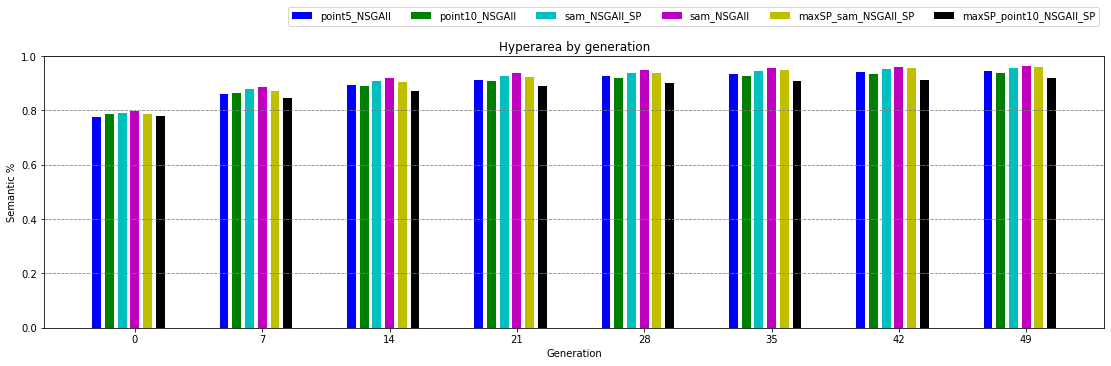

In [31]:
fig, ax = plt.subplots(1, figsize=(19, 5))
#for i in range(len(semantic_damage_bars)):
for i,exp in enumerate(exp_idx):
    #plt.bar([x-x_space/2+(i*width) for x in range(n_gens)], semantic_damage_bars[exp][1], bottom = semantic_damage_bars[exp][2], color='red', width = width)
    values = semantic_damage_bars[exp][3]
    plt.bar([x-x_space/2+(i*width) for x in range(len(values))], values, color=colors[i], width = width-0.03)
plt.title("Hyperarea by generation")
#legends = ["Damage"] + [exp_names[i] for i in exp_idx]
legends = [exp_names[i] for i in exp_idx]
plt.legend(legends, bbox_to_anchor=(1,1.2), ncol=bars, frameon=True,loc="upper right")
#for i,exp in enumerate(exp_idx):
#    plt.bar([x-x_space/2+(i*width) for x in range(n_gens)], semantic_damage_bars[exp][1], bottom = semantic_damage_bars[exp][2], color='red', width = width-0.03)
plt.xlabel('Generation')
plt.ylabel('Semantic %')
ax.yaxis.grid(color='gray', linestyle='dashed')
plt.ylim(0,1)
#plt.xlim(-x_space,n_gens)
plt.xticks(list(range(len(range(0, max_gen, gen_jump)))),list(range(0, max_gen, gen_jump)))

plt.show()

   Gen  Avg_damaged_semantics_from_parent  Avg_improved_semantics_from_parent  \
0    0                           0.110715                            0.074503   
1    1                           0.108511                            0.062355   
2    2                           0.092004                            0.049837   
3    3                           0.100810                            0.050982   
4    4                           0.103342                            0.048928   

   Hyperarea  Avg_semantic_change_balance  Fitness_evals  
0   0.786857                    -0.036212      -0.036212  
1   0.805113                    -0.046156      -0.046156  
2   0.818584                    -0.042167      -0.042167  
3   0.833226                    -0.049829      -0.049829  
4   0.841317                    -0.054414      -0.054414  


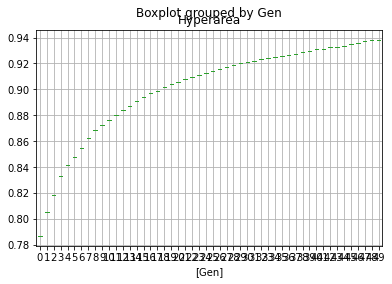

In [40]:
print(pd_logs[1].head())
boxplot = pd_logs[1].boxplot(column=[columns[3]], by = [columns[0]])